In [ ]:
#Import the necessary libraries(This was run on Kaggle as Colabs was crashing and getting disconnected)
import numpy as np
import pandas as pd
import seaborn as sns
import math
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
ratings = pd.read_csv("/content/drive/MyDrive/MLNS/ratings_book.csv")

#Exploratory Data Analysis

In [ ]:
ratings.shape

(1302316, 3)

In [ ]:
ratings.dtypes

userID       object
productID    object
Rating        int64
dtype: object

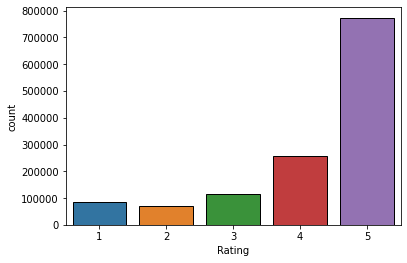

In [ ]:
#Countplot of the ratings, maximum user-products have got rating as 5 
sns.countplot(data=ratings, x='Rating');

In [ ]:
#Find the minimum and maximum ratings - It is between 1 and 5
print('Minimum rating is: %d' %(ratings.Rating.min()))
print('Maximum rating is: %d' %(ratings.Rating.max()))

Minimum rating is: 1
Maximum rating is: 5


In [ ]:
#Check for missing values - There are no missing values, so no imputation required
print('Number of missing values across columns: \n',ratings.isna().sum())

Number of missing values across columns: 
 userID       0
productID    0
Rating       0
dtype: int64


In [ ]:
#Number of products (7112)) is less than number of users(34733), so item-item colaborative filtering would make sense
#instead of user-user colaborative filtering
print("Music Data Summary")
print("\nTotal # of Ratings :",ratings.shape[0])
print("Total # of Users   :", len(np.unique(ratings.userID)))
print("Total # of Products  :", len(np.unique(ratings.productID)))
print("\n")

Music Data Summary

Total # of Ratings : 1302316
Total # of Users   : 34733
Total # of Products  : 7112




In [ ]:
#for consistency we remove duplicates
ratings.drop_duplicates(inplace=True)

In [ ]:
#Analysis of how many product rating given by a particular user 
no_of_rated_products_per_user = ratings.groupby(by='userID')['Rating'].count().sort_values(ascending=False)
no_of_rated_products_per_user.head()

userID
ATVPDKIKX0DER     22113
A3UN6WX5RRO2AG    10224
A1K1JW1C5CUSUZ      908
A3GBMAJNL0YQ1K      739
A2ODBHT4URXVXQ      703
Name: Rating, dtype: int64

In [ ]:
no_of_rated_products_per_user.describe().astype(int).T

count    34733
mean        22
std        134
min          1
25%         11
50%         14
75%         21
max      22113
Name: Rating, dtype: int64

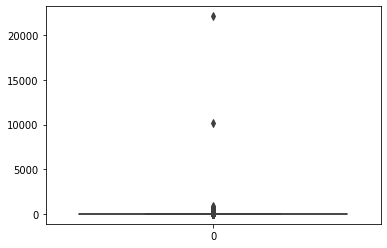

In [ ]:
#Boxplot shows that we have few users who rate many items (appearing in outliers) but majority rate very few items
sns.boxplot(data=no_of_rated_products_per_user);

In [ ]:
#We have only 2318 users who have rated more than or equal to 50 products
print('\n Users that rated more then 50 products : {}\n'.format(sum(no_of_rated_products_per_user >= 50)) )


 Users that rated more then 50 products : 2318



In [ ]:
#Getting the new dataframe which contains users who has given 50 or more ratings
new_df=ratings.groupby("userID").filter(lambda x:x['Rating'].count() >=50)
new_df.head()

,userID,productID,Rating
1,A93ZSJWZ4375R,0767905288,5
2,A3VZH0PWLQ9BB1,0767905288,4
4,A2H27QB13MDOLB,0767905288,5
5,A1AYJGVOUJ3F8R,0767905288,1
15,A1GC9A61EUU5JZ,0767905288,5


In [ ]:
#Products also have skewed ratings with majority of the products having very few ratings
no_of_ratings_per_product = new_df.groupby(by='productID')['Rating'].count().sort_values(ascending=False)


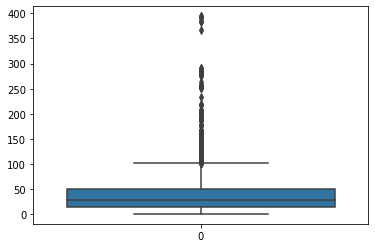

In [ ]:
#Boxplot shows that we have few products with large number of ratings, but majority have very low ratings
sns.boxplot(data=no_of_ratings_per_product);

In [ ]:
#Average rating of the product across users
new_df.groupby('productID')['Rating'].mean().sort_values(ascending=False).head()

productID
1886939470    5.0
0963942999    5.0
0139211640    5.0
0812933176    5.0
1591298733    5.0
Name: Rating, dtype: float64

In [ ]:
#Total # of ratings for product
new_df.groupby('productID')['Rating'].count().sort_values(ascending=False).head()

productID
0807281751    394
0590353403    394
0786222727    392
0807281956    391
0939173344    384
Name: Rating, dtype: int64

In [ ]:
ratings_mean_count = pd.DataFrame(new_df.groupby('productID')['Rating'].mean())
ratings_mean_count['rating_counts'] = pd.DataFrame(new_df.groupby('productID')['Rating'].count())
#Products which have high rating have fewer user reviews as seen below
ratings_mean_count.head()

,Rating,rating_counts
productID,,
0001054600,3.979592,49
0006490603,4.000000,7
0020425651,3.928571,14
0020446500,3.000000,10
0027110303,3.666667,18


In [ ]:
#The maximum number of ratings received for a product is 119
ratings_mean_count['rating_counts'].max()

394

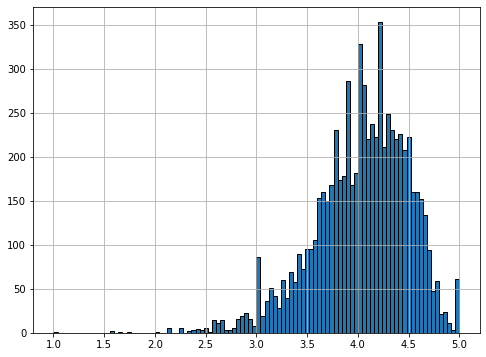

In [ ]:
#We see a left skewed distribution for the ratings
#There's a concentration of rating in 3.5-4.5
plt.figure(figsize=(8,6))
plt.rcParams['patch.force_edgecolor'] = True
ratings_mean_count['Rating'].hist(bins=100)

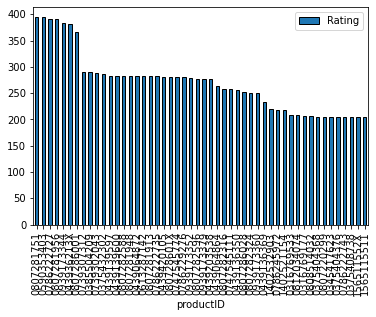

In [ ]:
#Below is the bar graph showing product list of top 30 most popular products
popular_products = pd.DataFrame(new_df.groupby('productID')['Rating'].count())
most_popular = popular_products.sort_values('Rating', ascending=False)
most_popular.head(50).plot(kind = "bar")

#Collaborative filtering (Item-Item)


In [ ]:
!pip install surprise

In [ ]:
from surprise import KNNWithMeans
from surprise import Dataset
from surprise import accuracy
from surprise import Reader
import os
from surprise.model_selection import train_test_split

In [ ]:
#Reading the dataset
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(new_df,reader)

In [ ]:
#Splitting the dataset
trainset, testset = train_test_split(data, test_size=0.3,random_state=10)

In [ ]:
# Use user_based true/false to switch between user-based or item-based collaborative filtering
algo = KNNWithMeans(k=5, sim_options={'name': 'pearson_baseline', 'user_based': False})
algo.fit(trainset)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


In [ ]:
# run the trained model against the testset
test_pred = algo.test(testset)

In [ ]:
test_pred

In [ ]:
# get RMSE
print("Item-based Model : Test Set")
accuracy.rmse(test_pred, verbose=True)

Item-based Model : Test Set
RMSE: 0.7739


0.7738658067574552

#Collaborative Filtering (model based)

In [ ]:
new_df1=new_df.head(10000)
ratings_matrix = new_df1.pivot_table(values='Rating', index='userID', columns='productID', fill_value=0)
ratings_matrix.head()

productID,0028632613,0060182970,0060194626,0060194804,0060194979,0060196246,0060234970,0060288140,0060291699,0060393408,...,1590070429,1590073991,1878923102,1881273628,1889392146,1891620401,1930097441,1931056331,8432215244,B00006JO6K
userID,,,,,,,,,,,,,,,,,,,,,
A105E427BB6J65,0,0,0,0.0,0,4,0.0,0.0,0.0,0,...,0,0.0,0.0,0,0.0,0,0,0.0,0.0,2.0
A106016KSI0YQ,0,0,0,0.0,0,0,0.0,0.0,0.0,1,...,0,0.0,0.0,0,0.0,0,0,0.0,0.0,0.0
A106E1N0ZQ4D9W,0,0,0,0.0,0,0,0.0,0.0,0.0,0,...,0,0.0,0.0,0,0.0,0,0,0.0,0.0,0.0
A10872FHIJAKKD,0,0,0,0.0,0,0,0.0,0.0,0.0,0,...,0,0.0,0.0,0,0.0,0,0,0.0,0.0,0.0
A108AVF62U97NY,0,0,0,0.0,0,0,0.0,0.0,0.0,0,...,0,0.0,0.0,0,0.0,0,0,0.0,0.0,0.0


In [ ]:
ratings_matrix.shape

(2188, 280)

In [ ]:
#Transpose the matrix
X = ratings_matrix.T
X

userID,A105E427BB6J65,A106016KSI0YQ,A106E1N0ZQ4D9W,A10872FHIJAKKD,A108AVF62U97NY,A10EH95EUDO9W3,A10HWJXUG67E7I,A10KKJMBY5L7TK,A10LWBOIZCF2QT,A10VOEBL5S337W,...,AZF69UA25SAWH,AZFX7FLEHCWXM,AZG7XWVU23I8P,AZGXZ2UUK6X,AZI0O32W4ZYGH,AZJV428E2H591,AZM09BO1FD418,AZPCELP6EEOJY,AZVZSGHKV0AO0,AZYFJ8OO3B1UH
productID,,,,,,,,,,,,,,,,,,,,,
0028632613,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0060182970,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0060194626,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0060194804,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0060194979,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1891620401,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1930097441,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1931056331,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
X1 = X

In [ ]:
#Decomposing the Matrix
from sklearn.decomposition import TruncatedSVD
SVD = TruncatedSVD(n_components=10)
decomposed_matrix = SVD.fit_transform(X)
decomposed_matrix.shape

(280, 10)

In [ ]:
#Correlation Matrix

correlation_matrix = np.corrcoef(decomposed_matrix)
correlation_matrix.shape

(280, 280)

In [ ]:
X.index[75]

'0399214240'

In [ ]:
i = "0399214240"

product_names = list(X.index)
product_ID = product_names.index(i)
product_ID

75

In [ ]:
#Correlation for all items with the item purchased by this customer based 
#on items rated by other customers people who bought the same product
correlation_product_ID = correlation_matrix[product_ID]
correlation_product_ID.shape

(280,)

In [ ]:
#Recommending top 25 highly correlated products in sequence
Recommend = list(X.index[correlation_product_ID > 0.65])

# Removes the item already bought by the customer
Recommend.remove(i) 

Recommend[0:24]

['0028632613',
 '0060194979',
 '0060234970',
 '0060288140',
 '0060291699',
 '0061007226',
 '0064401324',
 '006440823X',
 '0064409422',
 '0064471195',
 '0064472132',
 '0130893986',
 '0140374248',
 '0141800240',
 '0151262276',
 '0152016090',
 '015202199X',
 '0195067142',
 '0310219604',
 '031022358X',
 '031285787X',
 '0312868855',
 '0312869363',
 '0312890176']

#Popularity based

In [ ]:
#Split the data into 70% train and 30% test
train_data, test_data = train_test_split(new_df, test_size = 0.30, random_state=0)
print(train_data.head(5))


                userID   productID  Rating
196052   AZ0PCEZUTF5QO  0393320979       5
686876   ATVPDKIKX0DER  0393955524       1
925937  A30KEXFT9SILL6  0312203438       5
38153    AXCNBMLTW6HJV  0679720200       1
433347  A3P3UOHYBFRGJN  0679457895       4


In [ ]:
#Count of user_id for each unique product as recommendation score 
train_data_grouped = train_data.groupby('productID').agg({'userID': 'count'}).reset_index()
train_data_grouped.rename(columns = {'userID': 'score'},inplace=True)
train_data_grouped.head()

,productID,score
0,0001054600,34
1,0006490603,4
2,0020425651,12
3,0020446500,5
4,0027110303,15


In [ ]:
#Sort the products on recommendation score 
train_data_sort = train_data_grouped.sort_values(['score', 'productID'], ascending = [0,1])     
#Generate a recommendation rank based upon score 
train_data_sort['Rank'] = train_data_sort['score'].rank(ascending=0, method='first') 
#Get the top 5 recommendations 
popularity_recommendations = train_data_sort.head(5) 
popularity_recommendations 

,productID,score,Rank
3492,0590353403,287,1.0
5474,0807281751,272,2.0
5481,0807281956,270,3.0
2294,043936213X,264,4.0
5151,0786222727,263,5.0


In [ ]:
# Use popularity based recommender model to make predictions for a user
# As we note this list will be same for all the users
def recommend(user_id):     
    user_recommendations = popularity_recommendations 
          
    #Add user_id column for which the recommendations are being generated 
    user_recommendations['userId'] = user_id 
      
    #Bring user_id column to the front 
    cols = user_recommendations.columns.tolist() 
    cols = cols[-1:] + cols[:-1] 
    user_recommendations = user_recommendations[cols] 
          
    return user_recommendations 

In [ ]:
# This list a list of users (those that have commented the most but this is random) since this is popularity based recommendation method irrespective of user 
# same products will be suggested
find_recom = ['A105E427BB6J65',	'A106016KSI0YQ',	'A106E1N0ZQ4D9W',	'A10872FHIJAKKD',	'A108AVF62U97NY']   
for i in find_recom:
    print("Here is the recommendation for the userId: %s\n" %(i))
    print(recommend(i))    
    print("\n") 

Here is the recommendation for the userId: A105E427BB6J65

              userId   productID  score  Rank
3492  A105E427BB6J65  0590353403    287   1.0
5474  A105E427BB6J65  0807281751    272   2.0
5481  A105E427BB6J65  0807281956    270   3.0
2294  A105E427BB6J65  043936213X    264   4.0
5151  A105E427BB6J65  0786222727    263   5.0


Here is the recommendation for the userId: A106016KSI0YQ

             userId   productID  score  Rank
3492  A106016KSI0YQ  0590353403    287   1.0
5474  A106016KSI0YQ  0807281751    272   2.0
5481  A106016KSI0YQ  0807281956    270   3.0
2294  A106016KSI0YQ  043936213X    264   4.0
5151  A106016KSI0YQ  0786222727    263   5.0


Here is the recommendation for the userId: A106E1N0ZQ4D9W

              userId   productID  score  Rank
3492  A106E1N0ZQ4D9W  0590353403    287   1.0
5474  A106E1N0ZQ4D9W  0807281751    272   2.0
5481  A106E1N0ZQ4D9W  0807281956    270   3.0
2294  A106E1N0ZQ4D9W  043936213X    264   4.0
5151  A106E1N0ZQ4D9W  0786222727    263   5.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pyda

In [ ]:
train_data_sort.head()

,productID,score,Rank
3492,0590353403,287,1.0
5474,0807281751,272,2.0
5481,0807281956,270,3.0
2294,043936213X,264,4.0
5151,0786222727,263,5.0


In [ ]:
test_data.head()

,userID,productID,Rating
12198,AE9WERKN1ICUL,0842365516,1
682806,A1M0U4JMQVKAZT,1572701900,5
926138,A93ZSJWZ4375R,0399144463,4
675777,A3NFP78MGDC6ZC,0553801376,5
696576,A1ZX985S49O7K6,0060536977,4


In [ ]:
#Calculating the RMSE of the popularity based recommendation system
#Rating present in the test data is the actual rating (Act_rating)
test_data2 = test_data.copy()
#ratings.drop(['timestamp'], axis=1,inplace=True)
test_data2.drop(['userID'],axis=1,inplace=True)
test_data2.rename(columns = {'Rating':'Act_rating'}, inplace = True)

In [ ]:
#Count of user_id for each unique product as recommendation score 
train_data_grouped2 = train_data.groupby('productID').agg({'Rating': 'sum'}).reset_index()
train_data_grouped2.rename(columns = {'Rating': 'Sum_rating'},inplace=True)
train_data_grouped2.head()

,productID,Sum_rating
0,0001054600,138
1,0006490603,17
2,0020425651,46
3,0020446500,15
4,0027110303,58


In [ ]:
train_data_inner = pd.merge(train_data_grouped2, train_data_sort)
train_data_inner.head()

,productID,Sum_rating,score,Rank
0,0001054600,138,34,1792.0
1,0006490603,17,4,6688.0
2,0020425651,46,12,4869.0
3,0020446500,15,5,6485.0
4,0027110303,58,15,4271.0


In [ ]:
#Obtain the average rating of the product across users
train_data_inner["Avg_Rating"] = train_data_inner["Sum_rating"]/train_data_inner["score"]
train_data_inner.head()

,productID,Sum_rating,score,Rank,Avg_Rating
0,0001054600,138,34,1792.0,4.058824
1,0006490603,17,4,6688.0,4.250000
2,0020425651,46,12,4869.0,3.833333
3,0020446500,15,5,6485.0,3.000000
4,0027110303,58,15,4271.0,3.866667


In [ ]:
#Merge the train data having average rating with the test data having actual rating at product level
test_data_inner = pd.merge(train_data_inner, test_data2)
test_data_inner.head()

,productID,Sum_rating,score,Rank,Avg_Rating,Act_rating
0,0001054600,138,34,1792.0,4.058824,3
1,0001054600,138,34,1792.0,4.058824,1
2,0001054600,138,34,1792.0,4.058824,5
3,0001054600,138,34,1792.0,4.058824,5
4,0001054600,138,34,1792.0,4.058824,5


In [ ]:
#Now the merged data has both actual rating (Act_rating) and predicted rating (Avg_rating)
#Now RMSE can be calculated
test_data_inner.head()

,productID,Sum_rating,score,Rank,Avg_Rating,Act_rating
0,0001054600,138,34,1792.0,4.058824,3
1,0001054600,138,34,1792.0,4.058824,1
2,0001054600,138,34,1792.0,4.058824,5
3,0001054600,138,34,1792.0,4.058824,5
4,0001054600,138,34,1792.0,4.058824,5


In [ ]:
#RMSE for popularity based recommender system is 1.217
mse = mean_squared_error(test_data_inner["Act_rating"], test_data_inner["Avg_Rating"])
rmse = math.sqrt(mse)
print("RMSE for popularity based recommendation system:", rmse)

RMSE for popularity based recommendation system: 1.104511958661463


#Item-Item 


In [ ]:
#Upgrading pip as pakage update for turicreate was giving issues
!pip install --upgrade pip
!pip install -U --use-feature=2020-resolver turicreate



In [ ]:
#Importing turicreate
#This package takes SFrame instead of dataframe so typecasting accordingly
import turicreate
train_data2 = turicreate.SFrame(train_data)
test_data2 = turicreate.SFrame(test_data)

In [ ]:
#Training the model for item-item similarity recommende
item_sim_model = turicreate.item_similarity_recommender.create(train_data2, 
                                                               user_id='userID', 
                                                               item_id='productID', 
                                                               target='Rating', 
                                                               similarity_type='cosine')

Preparing data set.

Data has 189653 observations with 2318 users and 7082 items.

Data prepared in: 0.572515s

Training model from provided data.

Gathering per-item and per-user statistics.

+--------------------------------+------------+

| Elapsed Time (Item Statistics) | % Complete |

+--------------------------------+------------+

| 5.608ms                        | 43         |

| 12.172ms                       | 100        |

+--------------------------------+------------+

Setting up lookup tables.

Processing data in one pass using dense lookup tables.

+-------------------------------------+------------------+-----------------+

| Elapsed Time (Constructing Lookups) | Total % Complete | Items Processed |

+-------------------------------------+------------------+-----------------+

| 134.419ms                           | 0                | 1               |

| 1.86s                               | 100              | 7082            |

+-------------------------------------+------------------+-----------------+

Finalizing lookup tables.

Generating candidate set for working with new users.

Finished training in 2.93709s

In [ ]:
#Making top 5 recommendations based on item-item similarity recommender system
item_sim_recomm = item_sim_model.recommend(users=['A105E427BB6J65','A106016KSI0YQ',	'A106E1N0ZQ4D9W',
                                                  'A10872FHIJAKKD',	'A108AVF62U97NY'],k=5)
item_sim_recomm.print_rows(num_rows=25)

+----------------+------------+---------------------+------+
|     userID     | productID  |        score        | rank |
+----------------+------------+---------------------+------+
| A105E427BB6J65 | 156895199X | 0.44980026375163684 |  1   |
| A105E427BB6J65 | 1565114663 | 0.43037781796672125 |  2   |
| A105E427BB6J65 | 0060502258 |  0.3932537666775964 |  3   |
| A105E427BB6J65 | 0060173289 |  0.3525726253336126 |  4   |
| A105E427BB6J65 | 0525946268 | 0.34461713514544745 |  5   |
| A106016KSI0YQ  | 0679879242 |  0.6313363975948758 |  1   |
| A106016KSI0YQ  | 0613026993 |  0.6279000295533075 |  2   |
| A106016KSI0YQ  | 0679893105 |  0.6167379087871976 |  3   |
| A106016KSI0YQ  | 0345413350 |  0.6049826860427856 |  4   |
| A106016KSI0YQ  | 0394895894 | 0.25270881652832033 |  5   |
| A106E1N0ZQ4D9W | 0440215625 |   0.29590629639588  |  1   |
| A106E1N0ZQ4D9W | 055347331X | 0.29523027365601906 |  2   |
| A106E1N0ZQ4D9W | 055371452X |  0.2911404957921486 |  3   |
| A106E1N0ZQ4D9W | 03853

In [ ]:
#Get the item-item recommender RMSE value, value is 4.14 which is much worse than popularity based recommender system
item_rmse = item_sim_model.evaluate_rmse(test_data2,'Rating')

In [ ]:
item_rmse["rmse_overall"]

4.080267128406679

#Matrix factorization model

In [ ]:
import turicreate

In [ ]:
#This package takes SFrame instead of dataframe so typecasting accordingly
import turicreate
train_data2 = turicreate.SFrame(train_data)
test_data2 = turicreate.SFrame(test_data)

In [ ]:
#Build a matrix based factorization model recommender system
factorization_model = turicreate.factorization_recommender.create(train_data2, 
                                                                  user_id='userID', 
                                                                  item_id='productID', 
                                                                  target='Rating')

Preparing data set.

Data has 189653 observations with 2318 users and 7082 items.

Data prepared in: 0.643716s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 8        |

| regularization                 | L2 Regularization on Factors                     | 1e-08    |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 1e-10    |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 23706 / 189653 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 25                | Not Viable                               |

| 1       | 6.25              | Not Viable                               |

| 2       | 1.5625            | Not Viable                               |

| 3       | 0.390625          | Not Viable                               |

| 4       | 0.0976562         | 0.532229                                 |

| 5       | 0.0488281         | 0.69264                                  |

| 6       | 0.0244141         | 0.783138                                 |

| 7       | 0.012207          | 0.895372                                 |

+---------+-------------------+------------------------------------------+

| Final   | 0.0976562         | 0.532229                                 |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 130us        | 1.31142           | 1.14517               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 121.777ms    | 1.13414           | 1.06494               | 0.0976562   |

| 2       | 200.601ms    | 0.933027          | 0.965906              | 0.0580668   |

| 3       | 301.896ms    | 0.762101          | 0.872943              | 0.042841    |

| 4       | 408.387ms    | 0.639797          | 0.799818              | 0.0345267   |

| 5       | 468.329ms    | 0.563732          | 0.750753              | 0.029206    |

| 10      | 1.06s        | 0.430521          | 0.656035              | 0.017366    |

| 50      | 4.96s        | 0.322615          | 0.567818              | 0.00308816  |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 0.319115

Final training RMSE: 0.564727

In [ ]:
#Recommend top 5 products for 5 users basis matrix factorization method
factorization_recomm = factorization_model.recommend(users=['ATVPDKIKX0DER','A3UN6WX5RRO2AG',
                                                            'A9Q28YTLYREO7','A1GN8UJIZLCA59','A1J5KCZC8CMW9I'],k=5)
factorization_recomm.print_rows(num_rows=10)

+----------------+------------+-------------------+------+
|     userID     | productID  |       score       | rank |
+----------------+------------+-------------------+------+
| ATVPDKIKX0DER  | 0380710811 | 4.421881363811026 |  1   |
| ATVPDKIKX0DER  | 0740713922 | 4.326271460475454 |  2   |
| ATVPDKIKX0DER  | 0743227441 | 4.277919338168631 |  3   |
| ATVPDKIKX0DER  | 0312245475 | 4.270431206645498 |  4   |
| ATVPDKIKX0DER  | 0740721909 | 4.220502064647207 |  5   |
| A3UN6WX5RRO2AG | 0385498799 | 5.988885508002768 |  1   |
| A3UN6WX5RRO2AG | 1568951841 | 5.900780067862997 |  2   |
| A3UN6WX5RRO2AG | 0312868855 | 5.890677795829306 |  3   |
| A3UN6WX5RRO2AG | 0375760393 | 5.809672937812338 |  4   |
| A3UN6WX5RRO2AG | 1563058766 |  5.80600772899581 |  5   |
+----------------+------------+-------------------+------+
[25 rows x 4 columns]



In [ ]:
fcm_rmse2 = factorization_model.evaluate_rmse(test_data2,'Rating')
fcm_rmse2["rmse_overall"]

0.9158229068739882